In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F

/mnt/lun1/home/dbw/anaconda3/envs/cvnets/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 设置设备为GPU（如果可用）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 定义超参数
num_epochs = 50
batch_size = 128
learning_rate = 0.001

In [3]:
# 加载和预处理CIFAR-10数据集
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
# 定义Vision Transformer模型
class VisionTransformer(nn.Module):
    def __init__(self, num_classes=10, image_size=32, patch_size=4, hidden_dim=128, num_heads=8, num_layers=1):
        super(VisionTransformer, self).__init__()
        
        self.embedding = nn.Conv2d(3, hidden_dim, kernel_size=patch_size, stride=patch_size)
        self.transformer = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads), num_layers)
        self.fc = nn.Linear(hidden_dim * (image_size // patch_size) ** 2, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.flatten(2).permute(2, 0, 1)
        x = self.transformer(x)
        x = x.permute(1, 0, 2).flatten(1)
        x = self.fc(x)
        return x

In [5]:
# 初始化VIT模型
model = VisionTransformer().to(device)

# 定义损失函数和优化器 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 定义记录训练损失、测试损失和准确度的列表
train_loss_list = []
test_loss_list = []
accuracy_list = []

In [6]:
# 训练模型
total_step = len(train_loader)
for epoch in range(num_epochs):
    train_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # 前向传播
        outputs = model(images)
        loss = criterion(outputs, labels)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

        if (i + 1) % 100 == 0:
            print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}"
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

    # 计算平均训练损失
    train_loss /= len(train_loader)
    train_loss_list.append(train_loss)

    # 测试模型
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # 计算平均测试损失和准确度
    test_loss /= len(test_loader)
    test_loss_list.append(test_loss)
    accuracy = 100 * correct / total
    accuracy_list.append(accuracy)

    print("Epoch [{}/{}], Test Loss: {:.4f}, Test Accuracy: {:.2f}%".format(epoch + 1, num_epochs, test_loss, accuracy))



Epoch [1/50], Step [100/391], Loss: 1.7015
Epoch [1/50], Step [200/391], Loss: 1.5661
Epoch [1/50], Step [300/391], Loss: 1.4420
Epoch [1/50], Test Loss: 1.4095, Test Accuracy: 49.50%
Epoch [2/50], Step [100/391], Loss: 1.3344
Epoch [2/50], Step [200/391], Loss: 1.2819
Epoch [2/50], Step [300/391], Loss: 1.2627
Epoch [2/50], Test Loss: 1.2392, Test Accuracy: 55.90%
Epoch [3/50], Step [100/391], Loss: 1.0058
Epoch [3/50], Step [200/391], Loss: 1.1810
Epoch [3/50], Step [300/391], Loss: 1.1331
Epoch [3/50], Test Loss: 1.1804, Test Accuracy: 58.91%
Epoch [4/50], Step [100/391], Loss: 1.1266
Epoch [4/50], Step [200/391], Loss: 1.2504
Epoch [4/50], Step [300/391], Loss: 1.1216
Epoch [4/50], Test Loss: 1.1053, Test Accuracy: 60.98%
Epoch [5/50], Step [100/391], Loss: 1.0363
Epoch [5/50], Step [200/391], Loss: 1.1257
Epoch [5/50], Step [300/391], Loss: 1.0822
Epoch [5/50], Test Loss: 1.0902, Test Accuracy: 61.33%
Epoch [6/50], Step [100/391], Loss: 1.1862
Epoch [6/50], Step [200/391], Loss: 1

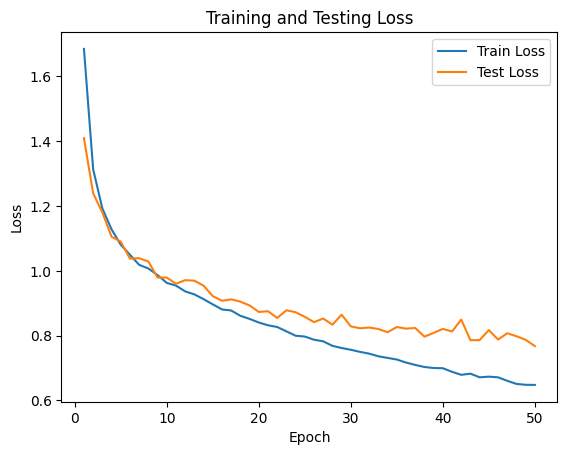

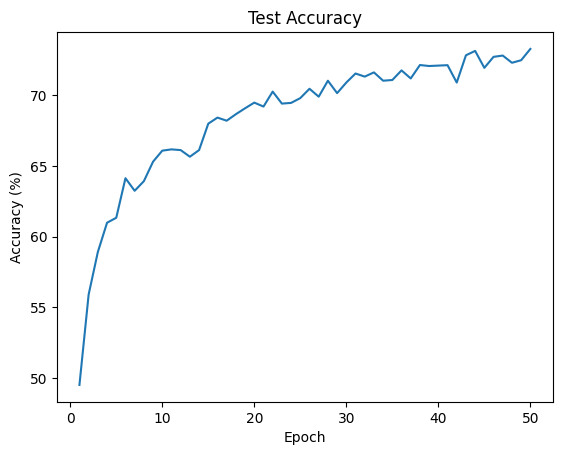

In [7]:
# 绘制训练损失和测试损失曲线
plt.plot(range(1, num_epochs + 1), train_loss_list, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_loss_list, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.show()

# 绘制准确度曲线
plt.plot(range(1, num_epochs + 1), accuracy_list)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.show()

In [8]:
import torch
# 保存模型参数
torch.save(model.state_dict(), '1ViT1.pth')